# News Sentiments

### Analysis of 100 Latest Tweets from 9/18 9 AM ET.  

Notes: Data may be mislead due to differing time spans of the tweets for each news outlet.  BBC World News sent out 100 tweets over 2 days while the other news outlets analyzed did so in less than 24 hours.  Events in or outside of this time span may skew one outlet against another.  

+ The polarity scores of the 500 tweets (last 100 from each news network over the timespan indicated) were almost perfectly split between negative, nuetral, and positive polarity scores.  
+ BBC World had almost 20 more tweets rated with a negative polarity in their last 100 tweets than any other network inspected.
+ CNN and New York Times were the only networks with the last 100 tweets having an positive average polarity score at the time of sampling.  
+ Removing perfectly neutral polarity scores, a random tweet taken from the sample is more likely to have a polarity of more than .25 or below -.25.  
+ BBC World had an average polarity score at least 13 points lower than other networks.  

In [31]:
#dependences
import tweepy
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import keys #twitter keys and tokens

In [11]:
#import vader for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [12]:
#get keys
consumer_key = keys.CONSUMER_KEY
consumer_secret = keys.CONSUMER_SECRET
access_token = keys.ACCESS_TOKEN
access_token_secret = keys.ACCESS_SECRET

In [13]:
#autheticate
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [111]:
#make dictionary of twitter SNs, network names, and colors for graphs
news_labels = {'CNN': 
                   {'name': 'CNN', 
                    'color': 'red'}, 
               'BBCWorld': 
                   {'name': 'BBC World News', 
                    'color': 'blue'}, 
               'CBSNews': 
                   {'name': 'CBS', 
                    'color': 'lightblue'},
               'nytimes': 
                   {'name': 'New York Times', 
                    'color': 'green'}, 
               'FoxNews': 
                   {'name': 'Fox', 
                    'color': 'yellow'}}

In [16]:
news_dict = {
    "Screen Name": [],
    "Tweet": [],
    "Date": [],
    "Compound Score": [],
    "Positive Score": [],
    "Negative Score": [],
    "Neutral Score": [],
    "Tweets Ago": []
}

In [17]:
# loop through SNs in dictionary
for news_org in news_labels.keys():
    tweets_ago = 1 #counts tweets 1 - most current 100 - least current, resets for each news_org
    for x in range(5): # loops through 5 pages of 20 tweets
        if x == 0:
            response = api.user_timeline(news_org, count = 20) #most recent 20 tweets
        else:
            response = api.user_timeline(news_org, max_id = end_id-1 , count = 20) # next 20 most recent tweets each time
        for tweet in response: # disects each tweet and pulls necessary info
            text = tweet['text'] #tweet text
            date = tweet['created_at'] #time created
            convert_date = datetime.strptime(date, "%a %b %d %H:%M:%S %z %Y") #converts date to sortable time
            user = tweet['user']['screen_name'] #SN of user
            end_id = tweet['id'] # gets id of tweet to be used in loop for next 20 results
            scores = analyzer.polarity_scores(text) # scores the text in tweet using VADER
            news_dict['Screen Name'].append(user) # adds SN to dict
            news_dict['Tweet'].append(text) # adds tweet text to dict
            news_dict['Date'].append(convert_date) # adds converted date to dict
            news_dict['Compound Score'].append(scores['compound']) 
            news_dict['Positive Score'].append(scores['pos'])
            news_dict['Negative Score'].append(scores['neg'])
            news_dict['Neutral Score'].append(scores['neu'])
            news_dict['Tweets Ago'].append(tweets_ago)
            tweets_ago += 1 # sets tweets ago count for next record


In [19]:
#converts to dataframe
news_df = pd.DataFrame(news_dict) 

In [25]:
#preview
news_df.head()

,Compound Score,Date,Negative Score,Neutral Score,Positive Score,Screen Name,Tweet,Tweets Ago
0,0.0000,2017-09-18 13:02:37+00:00,0.000,1.000,0.000,CNN,What are ‘sponge cities’? They may just be Chi...,1
1,0.2732,2017-09-18 12:58:06+00:00,0.000,0.909,0.091,CNN,"RT @cnni: Here’s a rare look at Mount Paektu, ...",2
2,0.0000,2017-09-18 12:50:05+00:00,0.000,1.000,0.000,CNN,"With the golf retweet, Trump blunders into the...",3
3,-0.2263,2017-09-18 12:40:07+00:00,0.128,0.872,0.000,CNN,In Bangladesh's overcrowded Rohingya refugee c...,4
4,-0.6705,2017-09-18 12:37:08+00:00,0.244,0.756,0.000,CNN,Both suspects in last week's London train atta...,5


In [21]:
#check appr. length
len(news_df)

500

In [94]:
news_df.to_csv('Output_CSVs/news_analysis.csv')

In [100]:
by_org = news_df.groupby('Screen Name')

pos_count = news_df[news_df['Compound Score'] > 0].groupby('Screen Name')['Compound Score'].count()
neg_count = news_df[news_df['Compound Score'] < 0].groupby('Screen Name')['Compound Score'].count()
neu_count = news_df[news_df['Compound Score'] == 0].groupby('Screen Name')['Compound Score'].count()

polarity_df = pd.DataFrame({
    "Positive Compound Scores": pos_count,
    "Negative Compound Scores": neg_count,
    "Neutral Compound Scores": neu_count,
    "Total": pos_count + neg_count + neu_count
})
polarity_df

,Negative Compound Scores,Neutral Compound Scores,Positive Compound Scores,Total
Screen Name,,,,
BBCWorld,54,30,16,100
CBSNews,30,45,25,100
CNN,29,26,45,100
FoxNews,35,32,33,100
nytimes,21,39,40,100


In [123]:
neg_sum = polarity_df['Negative Compound Scores'].sum()
neu_sum = polarity_df['Neutral Compound Scores'].sum()
pos_sum = polarity_df['Positive Compound Scores'].sum()
total = neg_sum + pos_sum + neu_sum

totals_df = pd.DataFrame({
    "Total Negative": [neg_sum],
    "Total Positive": pos_sum,
    "Total Neutral": neg_sum,
    "Total": total
})

totals_df

,Total,Total Negative,Total Neutral,Total Positive
0,500,169,169,159


In [110]:
time_max = by_org['Date'].max()
time_min = by_org['Date'].min()
time_diff = time_max - time_min
time_diff

avg_time_bt_tweets = time_diff/100
time_df = pd.DataFrame({
    "Time Span Between 1 and 100 Tweets Ago": time_diff,
    "Average Time Between Tweets": avg_time_bt_tweets
})

time_df

,Average Time Between Tweets,Time Span Between 1 and 100 Tweets Ago
Screen Name,,
BBCWorld,00:30:11.160000,2 days 02:18:36
CBSNews,00:12:00.530000,0 days 20:00:53
CNN,00:09:41.520000,0 days 16:09:12
FoxNews,00:11:35.540000,0 days 19:19:14
nytimes,00:09:45.020000,0 days 16:15:02


In [51]:
#finds date of most recent and least recent tweet
date_max = news_df['Date'].max().replace(tzinfo=timezone.utc).astimezone(tz = 'US/Eastern').strftime('%D: %r') + " (ET)"
date_min = date_min = news_df['Date'].min().replace(tzinfo=timezone.utc).astimezone(tz = 'US/Eastern').strftime('%D: %r') + " (ET)"

In [112]:
#plots scatter of news ords in dictionary with appr. colors and names from news_labels dict
plt.figure(figsize = (15,10))
plt.xlim(102,-2, -1)
plt.ylim(-1,1)
plt.title('Sentiment Analysis of the Last 100 Tweets of Popular News Outlets \n Samples taken from %s to %s' % (date_min, date_max),
         fontdict = {'fontsize': 20})
for news_org in news_labels.keys():
    df = news_df[news_df['Screen Name'] == news_org]
    yvals = df['Compound Score']
    xvals = df['Tweets Ago']
    labels = news_labels[news_org]['name'] #names from news_labels dict
    colors = news_labels[news_org]['color'] # colors from news labels dict
    plt.scatter(xvals,yvals, label = labels, s = 125, color = colors, edgecolor = 'black')


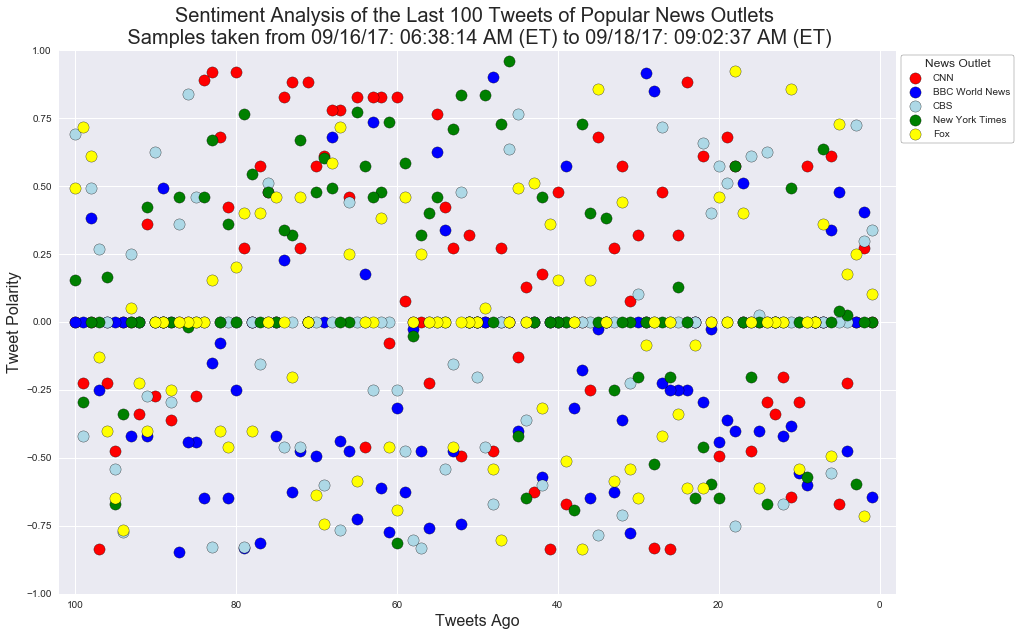

In [113]:
plt.legend(bbox_to_anchor = (1,1),
           frameon = True, 
           edgecolor = 'black', 
           facecolor = 'white',
           title = "News Outlet")
plt.xlabel('Tweets Ago',
          fontdict = {'fontsize': 16})
plt.ylabel('Tweet Polarity',
          fontdict = {'fontsize': 16})
plt.savefig('Output_Graphs/tweets_scatter.png', bbox_inches = 'tight')
plt.show()

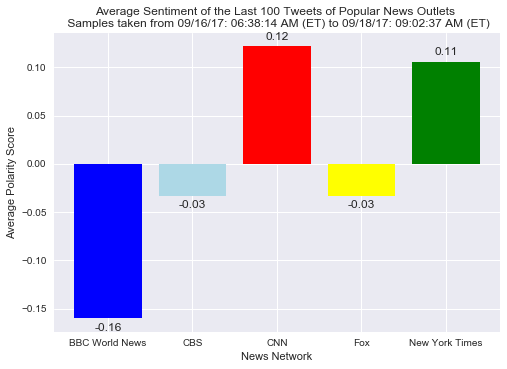

In [114]:
# group by SN and find average of each group
scores_by_org = news_df.groupby('Screen Name')['Compound Score'].mean()

# bar chart of mean scores labels
plt.title('Average Sentiment of the Last 100 Tweets of Popular News Outlets \n Samples taken from %s to %s' % (date_min, date_max))
plt.xlabel('News Network')
plt.ylabel('Average Polarity Score')

# list from group by network
xlabels = scores_by_org.index
# location of each bar
xvals = np.arange(len(scores_by_org))

count = 0 # for x coord location of value label

#create each value label
for score in scores_by_org: 
    if score < 0: #for neg scores, put label under
        height = score - .01
    else: # for + scores, put label above
        height = score + .01
    plt.text(count, height, str(round(score, 2)), ha = 'center', va = 'center')
    count += 1
plt.bar(xvals, 
        scores_by_org, 
        color = [news_labels[x]['color'] for x in xlabels], # sets colors from news_labels dict from xlabel list
        tick_label = [news_labels[x]['name'] for x in xlabels]) # sets x tick labels from news_labels dict
plt.savefig('Output_Graphs/average_scores.png')
plt.show()